
#### HA3 - Unsupervised Learning (Clustering)

GROUP 19  
Cátia Antunes (60494) - 10h<br>Donato Aveiro (46269) - 5h<br>Márcia Vital (59488) - 10h<br>Sean Gorman (59492) - 5h

In [2]:
# Install the following packages if needed:
#!pip install yellowbrick 

#### Relevant libraries and packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from typing import List
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, spectral_clustering, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score,  homogeneity_completeness_v_measure, completeness_score, v_measure_score, precision_score, recall_score, homogeneity_score, silhouette_samples
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from warnings import filterwarnings
filterwarnings('ignore')

#### Functions used in this notebook:

In [3]:
def elbow_method(dataset: np.ndarray, K: List[int], title) -> None:
    """Function that plots the elwbows for KMeans and KMeans++ for a given dataset and a list of Ks"""
    sum_of_squared_distances_KMEANS = []
    sum_of_squared_distances_KMEANSPP = []
    
    for k in K:
        km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=300, random_state=0)
        km = km.fit(dataset)
        sum_of_squared_distances_KMEANS.append(km.inertia_)

    for k in K:
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=0)
        km = km.fit(dataset)
        sum_of_squared_distances_KMEANSPP.append(km.inertia_)
    
    # set size of plot
    #plt.figure(figsize=(5, 5))
    plt.plot(K, sum_of_squared_distances_KMEANS, 'bx-', label='KMeans')
    plt.plot(K, sum_of_squared_distances_KMEANSPP, 'ro-', label='KMeans++')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Sum of squared distances')
    plt.title(title)
    plt.legend(loc='best')
    #plt.show()

In [62]:
def plot_elbow_scores2(datasets, k, title) -> pd.DataFrame:
    """Function that plots the silhouette scores for KMeans and KMeans++ for a given dataset and a list of Ks"""
    fig, axes = plt.subplots(1, 4, figsize=(20, 3))
    fig.suptitle(f'Distortion Score Elbow For Optimal k - {title}')
    
    data = []
    
    for i, ax in enumerate(axes):
        dataset_index = i
        ax.set_title(title[dataset_index])
        
        km_PP = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=0)
        visualizer_KMEANSPP = KElbowVisualizer(km_PP, k=(1,20), ax=ax)
        visualizer_KMEANSPP.fit(datasets[dataset_index])
        
        elbow_value = visualizer_KMEANSPP.elbow_value_
        elbow_score = visualizer_KMEANSPP.elbow_score_
        
        data.append({
            'Dataset': title[dataset_index],
            'Elbow Value': elbow_value,
            'Elbow Score': elbow_score
        })
    df = pd.DataFrame(data)
    plt.tight_layout()
    plt.show()
    return df


In [5]:
def run_clustering_algorithms(datasets, dataset_labels, k=3):
    """ Function that compares the different clustering algorithms for a given dataset and a given K"""

    results_list = []
    count = 1
    for dataset in datasets:
        # KMeans
        if count == 2:
            kmeans = KMeans(n_clusters= 9,init='k-means++', n_init=10, max_iter=100, random_state=42)
        else:
            kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
        kmeans.fit(dataset)

        #DBSCAN
        if count == 2:
            dbscan = DBSCAN(eps=1, min_samples=5)
        else:
            dbscan = DBSCAN(eps=0.1, min_samples=2)
        dbscan.fit(dataset)

        optics = OPTICS(min_samples=2, max_eps=1)
        optics.fit(dataset)

        # Agglomerative Clustering
        agg = AgglomerativeClustering(n_clusters=7)
        agg.fit(dataset)

        # Hierarchical Clustering
        hc = AgglomerativeClustering(n_clusters=2, linkage='single')
        hc.fit(dataset)

        # Gaussian Mixture Model
        gmm = GaussianMixture(n_components=7, random_state=42)
        gmm.fit(dataset)

        # Compute Silhouette scores and add to results dataframe
        results = pd.DataFrame(columns=['KMeans', 'DBSCAN', 'OPTICS', 'Agglomerative Clustering', 'Hierarchical Clustering', 'Gaussian Mixture Model'])
        results.loc['Silhouette Score'] = [round(silhouette_score(dataset, kmeans.labels_), 2),
                                           round(silhouette_score(dataset, dbscan.labels_), 2),
                                           round(silhouette_score(dataset, optics.labels_), 2),
                                           round(silhouette_score(dataset, agg.labels_), 2),
                                           round(silhouette_score(dataset, hc.labels_), 2),
                                           round(silhouette_score(dataset, gmm.predict(dataset)), 2)]
        
        results.loc['Calinski Harabasz Score'] = [round(calinski_harabasz_score(dataset, kmeans.labels_), 2),
                                                  round(calinski_harabasz_score(dataset, dbscan.labels_), 2),
                                                  round(calinski_harabasz_score(dataset, optics.labels_), 2),
                                                  round(calinski_harabasz_score(dataset, agg.labels_), 2),
                                                  round(calinski_harabasz_score(dataset, hc.labels_), 2),
                                                  round(calinski_harabasz_score(dataset, gmm.predict(dataset)), 2)]
        results_list.append(results)
        count += 1

    # Concatenate the results for each dataset
    results_df = pd.concat(results_list, keys=dataset_labels, axis=0)

    return results_df

In [ ]:
def grid_search(dataset, param_grid):
    '''Function that performs a grid search for the best parameters for DBSCAN'''
    best_score = -1
    best_params = {}

    for params in ParameterGrid(param_grid):
        eps = params['epsilon']
        min_samples = params['min_samples']

        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(dataset)

        if len(set(labels)) > 1:
            score = silhouette_score(dataset, labels)
            if score > best_score:
                best_score = score
                best_params = params

    return best_params

param_grid = {
    'epsilon': [0.05, 0.1, 0.5, 1.0, 2.0],
    'min_samples': [2, 3, 4, 5]
}

In [6]:
def load_data(df):
    """Load the data with any number of consecutive features, starting in column 0, where last column is the category class"""
    # load the data from a data frame already loaded in memory
    nc = df.shape[1] # number of columns
    matrix = df.values # get values of dataframe
    table_X = matrix [:, 1:nc-2] # get features (first columns)
    table_y = matrix [:, nc-1] # get category class (last column)
    features_names = df.columns.values[1:nc-2] #get features names
    target = df.columns.values[nc-1] # get target name
    return df, table_X, table_y, features_names, target

In [7]:
def get_clustering_results2(X, cluster_r,  y_pred, index_title):
    # Compute evaluation metrics
    sc = silhouette_score(X, cluster_r)
    chs = calinski_harabasz_score(X, cluster_r)

    results = pd.DataFrame(columns=['Silhouette Score', 'Calinski-Harabasz Score', 'Homogeneity Score', 'Completeness Score', 'V-measure Score'])
    if y_pred is not None:
        hc = homogeneity_score(cluster_r, y_pred)
        cs = completeness_score(cluster_r, y_pred)
        vms = v_measure_score(cluster_r, y_pred)
        results.loc[0] = [sc, chs, hc, cs, vms]
    else:
        results.loc[0] = [sc, chs, None, None, None]

    results.index = [index_title]
    return results

In [8]:
def drawSilhouette(X, labels, header="", pos=111):
    """Function that plots the silhouette scores side by side"""
    y_lower =10
    clusters = list(set(labels))
    n_clusters = len(clusters)

    fig = plt.gcf()
    ax1 = fig.add_subplot(pos)
    ax1.set_xlim([-0.5, 1])
    ax1.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    sil_avg = silhouette_score(X, labels)
    silhouette_values = silhouette_samples(X, labels)
    for i, c in enumerate(clusters):
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        color = cm.nipy_spectral(i / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cs_values, facecolor=color, edgecolor="k", alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3
    ax1.set_title("Silhouette plot "+ header)
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Clusters")
    ax1.axvline(x=sil_avg, c="r", linestyle="--")

    ax1.set_yticks([])

    return ax1

## Objective 1: Clustering

Our strategy involved using both the standard 2 datasets, train and unique, as well as a merged version of the dataset. We will also attempt to use PCA on the train dataset to highlight the most relevant features and see which of these 4 sets ultimately give the best results. So, the 4 datasets are as follows:
- Train
- Unique
- Merged 
- PCA

To conserve space, we won't be including all the optimization steps, but the optimized clustering methods will be used in the final analysis at the end of this objective. Let's prepare the data.

In [9]:
# Load the data
train_df = pd.read_csv("train.csv")
unique_m_df = pd.read_csv("unique_m.csv")

In [10]:
# Drop the identifiers (last column) from unique_m.csv
unique_m_df = unique_m_df.iloc[:, :-1]
# Remove the dependent variable (critical_temp) from both datasets 
train_X = train_df.iloc[:, :-1]
unique_m_X = unique_m_df.iloc[:, :-1]

The material column in the unique_m.csv file is just a label for each sample and doesn't provide any information about the superconducting properties. Therefore, it is not useful for analyzing, clustering or predicting those properties and can be ignored. In this task, the goal is to cluster the superconductivity data based on the material properties like atomic mass and radius. The dependent variable, critical_temp, representing the temperature at which a material becomes a superconductor, is not relevant for clustering analysis as it doesn't contribute to grouping similar data points together based on their intrinsic similarity. Hence, it should be removed from the dataset before conducting the clustering analysis.
We can merge the two datasets because they correspond to the same data instances and contain complementary information. The train.csv file contains the values of various features (such as lattice parameters, atomic weights, and more) that are known to influence superconductivity. The unique_m.csv file contains additional material properties such as the chemical formula, which could provide more insight into the superconducting properties. Merging the two datasets can create a more complete picture of the factors that affect superconductivity and can potentially improve the accuracy of the analysis.

In [11]:
# merge the two datasets
merged_X = pd.concat([train_X, unique_m_X], axis=1)
print(f"Merged data shape: {merged_X.shape}")

Merged data shape: (21263, 167)


Scaling
Normalization helps to scale the data so that all features have similar ranges of values. If different features have different scales, then some features may dominate the analysis simply because they have larger values, and this may lead to biased results. Normalizing the data allows each feature to contribute equally to the analysis. The MinMaxScaler function from the scikit-learn library is used to scale the data to the range [0,1].

In [12]:
# Normalize the data using min-max scaling
scaler = MinMaxScaler()
train_X_scaled = scaler.fit_transform(train_X)
unique_m_X_scaled = scaler.fit_transform(unique_m_X)
merged_X_scaled = scaler.fit_transform(merged_X)

In [13]:
pca = PCA()
train_X_pca = pca.fit_transform(train_X_scaled)

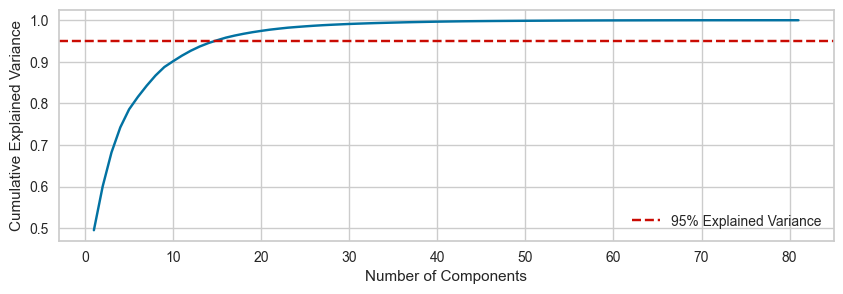

In [60]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 3))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.show()

### 1.1. Hierarchical Agglomerative Clustering (HAC)

In [16]:
data = train_X_scaled
linkage_methods = ["complete", "ward", "single", "average"]
k_values = range(2, 10)

results = []

for method in linkage_methods:
    for k in k_values:
        hca = AgglomerativeClustering(linkage=method, n_clusters=k)
        labels = hca.fit_predict(data)
        sil_score = silhouette_score(data, labels)

        result = {
            "Value of K": k,
            "Linkage Method": method,
            "Silhouette Score": sil_score
        }
        results.append(result)

In [17]:
silhouette_scores_df = pd.DataFrame(results)
silhouette_scores_df.sort_values(by="Silhouette Score", ascending=False, inplace=True)
silhouette_scores_df.head()

,Value of K,Linkage Method,Silhouette Score
24,2,average,0.406969
8,2,ward,0.374797
28,6,average,0.358273
29,7,average,0.353058
30,8,average,0.350122


The "average" linkage method, K=2 achieves the highest silhouette score of 0.406969. This suggests that using two clusters with the average linkage method resulted in well-separated and internally homogeneous clusters for the train_X_scaled dataset.

In [18]:
data = unique_m_X_scaled
linkage_methods = ["complete", "ward", "single", "average"]
k_values = range(2, 10)

results = []

for method in linkage_methods:
    for k in k_values:
        hca = AgglomerativeClustering(linkage=method, n_clusters=k)
        labels = hca.fit_predict(data)
        sil_score = silhouette_score(data, labels)

        result = {
            "Value of K": k,
            "Linkage Method": method,
            "Silhouette Score": sil_score
        }
        results.append(result)

In [19]:
silhouette_scores_df = pd.DataFrame(results)
silhouette_scores_df.sort_values(by="Silhouette Score", ascending=False, inplace=True)
silhouette_scores_df.head()

,Value of K,Linkage Method,Silhouette Score
16,2,single,0.810036
24,2,average,0.810036
25,3,average,0.803594
26,4,average,0.800054
27,5,average,0.799117


There are two combinations of K and linkage method that have the highest silhouette score of 0.810036 for the unique_m_X_scaled dataset:
- K=2, Linkage Method: single
- K=2, Linkage Method: average

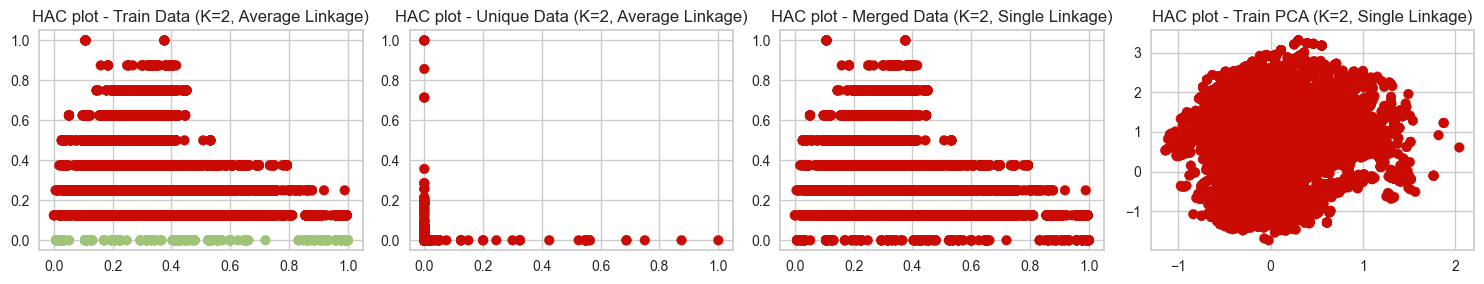

In [51]:
v1 = 3
v2 = 0
fig, axs = plt.subplots(1, 4)
fig.set_size_inches(15, 3)

# First subplot - Average Linkage
model = AgglomerativeClustering(linkage="average", n_clusters=2)
model.fit(train_X_scaled)
color_assigs = np.array(["r", "g", "b", "k"])[model.labels_]
axs[0].scatter(train_X_scaled[:, v1], train_X_scaled[:, v2], c=color_assigs)
axs[0].set_title('HAC plot - Train Data (K=2, Average Linkage)')

# First subplot - Average Linkage
model = AgglomerativeClustering(linkage="average", n_clusters=2)
model.fit(unique_m_X_scaled)
color_assigs = np.array(["r", "g", "b", "k"])[model.labels_]
axs[1].scatter(unique_m_X_scaled[:, v1], unique_m_X_scaled[:, v2], c=color_assigs)
axs[1].set_title('HAC plot - Unique Data (K=2, Average Linkage)')

# Second subplot - Single Linkage
model = AgglomerativeClustering(linkage="single", n_clusters=2)
model.fit(merged_X_scaled)
color_assigs = np.array(["r", "g", "b", "k"])[model.labels_]
axs[2].scatter(merged_X_scaled[:, v1], merged_X_scaled[:, v2], c=color_assigs)
axs[2].set_title('HAC plot - Merged Data (K=2, Single Linkage)')

# Second subplot - Single Linkage
model = AgglomerativeClustering(linkage="single", n_clusters=2)
model.fit(train_X_pca)
color_assigs = np.array(["r", "g", "b", "k"])[model.labels_]
axs[3].scatter(train_X_pca[:, v1], train_X_pca[:, v2], c=color_assigs)
axs[3].set_title('HAC plot - Train PCA (K=2, Single Linkage)')

plt.tight_layout()  # Adjust spacing between subplots if needed
plt.show()

### 1.2 K-Means Clustering

#### K-means vs K-means++  

Both are clustering algorithms used to group data points into distinct clusters. However, there is a significant difference between these two algorithms in the way they initialize their centroids.
K-means algorithm selects the initial centroids randomly, which can lead to suboptimal cluster formation. On the other hand, K-means++ algorithm improves the initial centroid selection by using a probabilistic approach.
In K-means++, the first centroid is selected randomly from the data points, and then subsequent centroids are selected based on their distance from the already selected centroids. Specifically, the probability of a data point being selected as the next centroid is proportional to the square of its distance from the nearest centroid that has already been chosen.
This process ensures that the centroids are well spread out and reduces the chances of the algorithm getting stuck in local optima. As a result, K-means++ often outperforms K-means in terms of clustering accuracy and convergence speed, especially when dealing with large datasets.
In summary, the main difference between K-means and K-means++ is the method used for selecting initial centroids. K-means uses random initialization, while K-means++ uses a more sophisticated probabilistic approach to select the initial centroids.

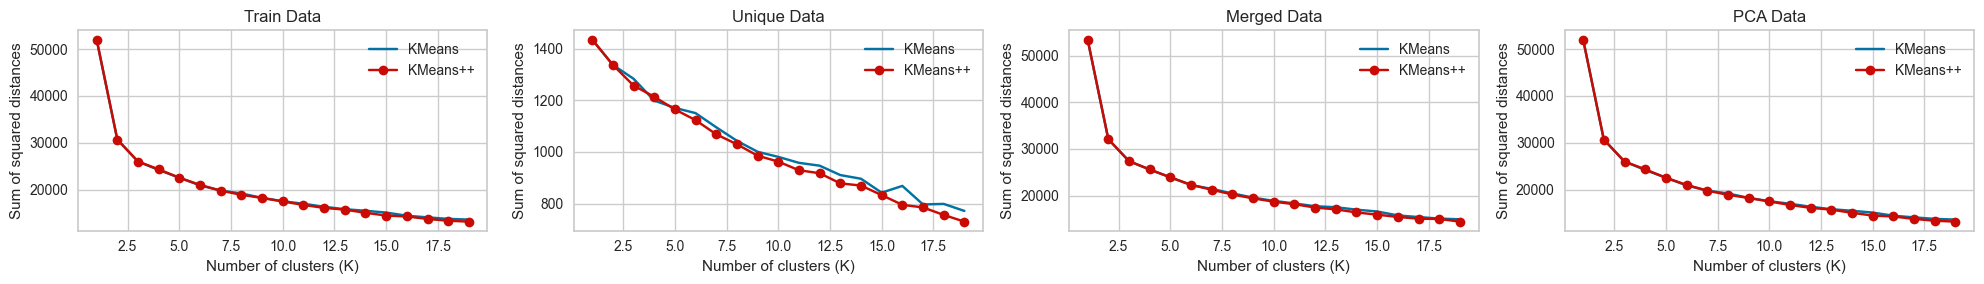

In [52]:
plt.figure(figsize=(20, 3))
plt.subplot(1, 4, 1)
elbow_method(train_X_scaled, range(1, 20), "Train Data")
plt.subplot(1, 4, 2)
elbow_method(unique_m_X_scaled, range(1, 20), "Unique Data")
plt.subplot(1, 4, 3)
elbow_method(merged_X_scaled, range(1, 20), "Merged Data")
plt.subplot(1, 4, 4)
elbow_method(train_X_pca, range(1, 20), "PCA Data")
plt.tight_layout()
plt.show()

#### K-Means with bad elbows?
The elbow method is a technique used in K-means clustering to determine the best number of clusters. It involves plotting the sum of squared distances (SSE) of data points to their nearest cluster center against the number of clusters. The "elbow" in the plot represents the point where adding more clusters no longer significantly reduces the SSE.
However, determining the exact location of the elbow can be challenging if the plot lacks a clear elbow. In such cases, additional metrics like the silhouette score can be useful. The silhouette score measures how well a data point belongs to its own cluster compared to other clusters, with higher scores indicating better clustering. By calculating the silhouette score at different numbers of clusters, we can compare the scores and validate the clustering results obtained at each point.
Incorporating the silhouette score into the elbow method provides supplementary information and validation for determining the optimal number of clusters, particularly when the SSE plot is unclear.

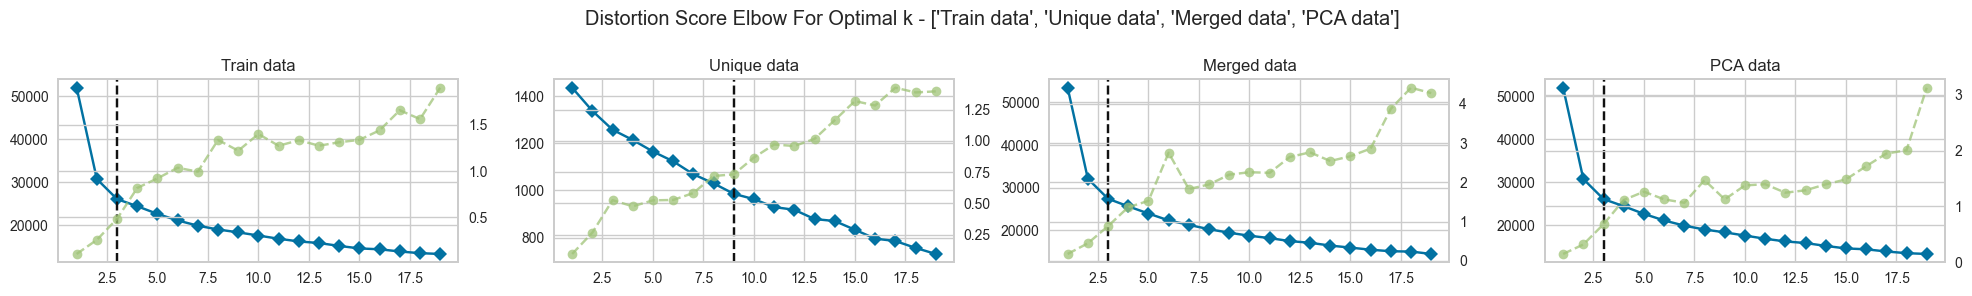

In [63]:
elbow_result = plot_elbow_scores2([train_X_scaled, unique_m_X_scaled, merged_X_scaled, train_X_pca], range(1, 20) , ["Train data", "Unique data", "Merged data", "PCA data"])

In [23]:
elbow_result

,Dataset,Elbow Value,Elbow Score
0,Train data,3,26042.953612
1,Unique data,9,985.636449
2,Merged data,3,27397.430207
3,PCA data,3,26042.953612


#### K-Means Results

- For the dataset train_X_scaled, the optimal number of clusters is 3, based on the elbow method (With either K-means or K-means++)
- For the dataset unique_X_scaled, the optimal number of clusters is 9, based on the elbow method (With either K-means or K-means++).
- For the dataset merged_X_scaled, the optimal number of clusters is 3, based on the elbow method (With either K-means or K-means++).
- K-Means and K-Means++ perform similarly in terms of clustering quality, but K-Means++ is faster to converge.

### 1.3 DBSCAN 

In [24]:
best_params = grid_search(train_X_scaled, param_grid)

print("Best hyperparameters found for train set:")
print(best_params)

Best hyperparameters found for train set:
{'epsilon': 0.1, 'min_samples': 2}


In [25]:
best_params = grid_search(unique_m_X_scaled, param_grid)

print("Best hyperparameters found unique set:")
print(best_params)

Best hyperparameters found unique set:
{'epsilon': 1.0, 'min_samples': 5}


In [26]:
best_params = grid_search(merged_X_scaled, param_grid)

print("Best hyperparameters found unique set:")
print(best_params)

Best hyperparameters found unique set:
{'epsilon': 0.1, 'min_samples': 2}


In [27]:
#Hyperparameter search for optics not shown for space reasons
"""Best hyperparameters found for train set: {'max_eps': 1.0, 'min_samples': 2}"""

optics = OPTICS(min_samples=2, max_eps=1)

# Step 5: Apply the clustering algorithm to your dataset
optics_labels = optics.fit_predict(train_X_scaled)

# Step 6: Evaluate the performance of the clustering algorithm using appropriate metrics
optics_silhouette_score = silhouette_score(train_X_scaled, optics_labels)

print("OPTICS Silhouette Score:", optics_silhouette_score)

OPTICS Silhouette Score: 0.5272055026128768


### 1.4. Comparison of Clustering Algorithms and Discussion

In [28]:
datasets = [train_X_scaled, unique_m_X_scaled, merged_X_scaled, train_X_pca]
dataset_labels = ["Train Data", "Unique Data", "Merged Data", "PCA Data"]
run_clustering_algorithms(datasets, dataset_labels ,k=3)

KMeans  DBSCAN  OPTICS  \
Train Data  Silhouette Score             0.35    0.47    0.53   
            Calinski Harabasz Score  10605.58   40.69   19.54   
Unique Data Silhouette Score             0.21    0.78    0.37   
            Calinski Harabasz Score   1224.96   70.80   10.62   
Merged Data Silhouette Score             0.34    0.47    0.52   
            Calinski Harabasz Score  10112.69   30.07   18.52   
PCA Data    Silhouette Score             0.35    0.47    0.53   
            Calinski Harabasz Score  10605.58   40.69   19.53   

                                     Agglomerative Clustering  \
Train Data  Silhouette Score                             0.21   
            Calinski Harabasz Score                   5209.55   
Unique Data Silhouette Score                             0.19   
            Calinski Harabasz Score                   1159.52   
Merged Data Silhouette Score                             0.19   
            Calinski Harabasz Score                   4889.52   
PCA Data    Silhouette Score                             0.21   
            Calinski Harabasz Score                   5209.55   

                                     Hierarchical Clustering  \
Train Data  Silhouette Score                            0.20   
            Calinski Harabasz Score                     1.70   
Unique Data Silhouette Score                            0.81   
            Calinski Harabasz Score                    61.96   
Merged Data Silhouette Score                            0.25   
            Calinski Harabasz Score                     2.04   
PCA Data    Silhouette Score                            0.20   
            Calinski Harabasz Score                     1.70   

                                     Gaussian Mixture Model  
Train Data  Silhouette Score                           0.18  
            Calinski Harabasz Score                 4995.03  
Unique Data Silhouette Score                          -0.06  
            Calinski Harabasz Score                  613.48  
Merged Data Silhouette Score                           0.18  
            Calinski Harabasz Score                 4625.18  
PCA Data    Silhouette Score                           0.18  
            Calinski Harabasz Score                 4995.03

Based on the information provided in the table, the Calinski Harabasz Score consistently yields higher values for the K-means algorithm compared to the Silhouette Score across different datasets, including Train Data, Unique Data, Merged Data, and PCA Data. This indicates that the clusters produced by K-means are more compact and well-separated, making the Calinski Harabasz Score a favorable metric to consider.

The Calinski Harabasz Score specifically evaluates the ratio of between-cluster dispersion to within-cluster dispersion, providing a measure of how well-separated the clusters are and how distinct they are from each other. The consistently higher Calinski Harabasz Scores obtained by K-means suggest that it excels in creating clusters that are both internally coherent and sufficiently separated.

By prioritizing the Calinski Harabasz Score, we can have confidence that the resulting clusters will exhibit strong cohesion within each cluster and clear separation between clusters. This is particularly relevant when the objective is to obtain distinct and well-defined clusters that accurately represent the underlying structure in the data.

Therefore, based on the table's results and the superior performance of K-means in terms of the Calinski Harabasz Score, it can be argued that selecting K-means using the Calinski Harabasz Score as the evaluation metric is a justifiable choice. It offers the advantage of producing compact, well-separated clusters that align with the inherent structure of the data

## Objective 2: Evaluating clustering with extrinsic methods

### 2.1 Creating classes for the dependent variable (critical_temp)

In [29]:
train_df = pd.read_csv("train.csv")
unique_m_df = pd.read_csv("unique_m.csv")

In [30]:
# Categorize critical_temp into specified classes by creating temperature classes for the train data and unique_m data
def categorize(temp):
    if temp < 1.0:
        return 'VeryLow'
    elif temp < 5.0:
        return 'Low'
    elif temp < 20.0:
        return 'Medium'
    elif temp < 100.0:
        return 'High'
    else:
        return 'VeryHigh'
    
# Remove the material column from unique_m_df
unique_m_df = unique_m_df.iloc[:, :-1]
    
# Add the category column to a copy of train_df and unique_m_df called train_df_cat and unique_m_df_cat

train_df_cat = train_df.copy() # create a copy of train_df
train_df_cat['category'] = train_df['critical_temp'].apply(categorize) # add new column to train_df_cat

unique_m_df_cat = unique_m_df.copy() # create a copy of unique_m_df
unique_m_df_cat['category'] = unique_m_df['critical_temp'].apply(categorize) # add new column to unique_m_df_cat

In [31]:
# Loading the data to test quality of clustering algorithms
df_t, X_t, y_t, feature_names_t, target_t = load_data(train_df_cat)
df_u, X_u, y_u, feature_names_u, target_u = load_data(unique_m_df_cat)

In [32]:
#Scale the data
scaler = MinMaxScaler()
X_t_scaled = scaler.fit_transform(X_t)
X_u_scaled = scaler.fit_transform(X_u)

### 2.2 Applying the clustering algos

In [33]:
# KMeans clustering for train_df (X_t)
K=3
kms_X_t = KMeans(n_clusters=K, init= "k-means++" , n_init=10 ,random_state=42).fit(X_t_scaled)

In [34]:
# HAC for unique_m_df (X_u)
K=2
hac_X_u = AgglomerativeClustering(n_clusters=K, linkage='single').fit(X_u_scaled)

In [35]:
# KMeams clustering for unique_m_df (X_u)
K=9
kms_X_u = KMeans(n_clusters=K, init= "k-means++", n_init=10 ,random_state=42).fit(X_u_scaled)

### 2.3 Evaluation of the clustering results using extrinsic methods

In [38]:
# Evaluating clustering results for train_df (X_t) - kms_X_t.labels_ 
j = get_clustering_results2(X_t_scaled, kms_X_t.labels_ , y_t, "Kmeans++ - Train Data")
i = get_clustering_results2(X_u_scaled, kms_X_u.labels_ , y_u, "Kmeans++ - Unique Data")
h = get_clustering_results2(X_u_scaled, hac_X_u.labels_ , y_u, "HAC - Unique Data")

In [39]:
N=len(X_t)
rand_clust_t = np.random.randint(K, size=N)
k = get_clustering_results2(X_t_scaled, rand_clust_t , y_t, "Random Clustering - Train Data")
N=len(X_u)
rand_clust_u = np.random.randint(K, size=N)
l = get_clustering_results2(X_u_scaled, rand_clust_u , y_u, "Random Clustering - Unique Data")

In [40]:
# Combine all dataframes into one
frames = [j, i, h, k, l]
result = pd.concat(frames)
result

,Silhouette Score,Calinski-Harabasz Score,Homogeneity Score,Completeness Score,V-measure Score
Kmeans++ - Train Data,0.349416,10531.692151,0.366209,0.295782,0.327249
Kmeans++ - Unique Data,0.217593,1217.209993,0.223430,0.196478,0.209089
HAC - Unique Data,0.810560,62.292517,0.297611,0.000223,0.000446
Random Clustering - Train Data,-0.010707,1.127772,0.000201,0.000343,0.000254
Random Clustering - Unique Data,-0.026099,1.057163,0.000290,0.000495,0.000366


### 2.4 Visualising the differences between the clustering results

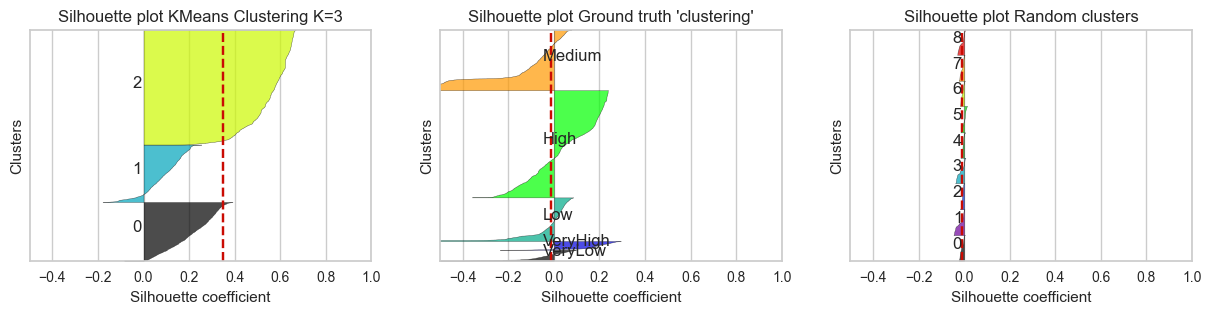

In [47]:
# Silhouette plots for train_df (X_t)
fig = plt.figure(figsize=(15, 3))
ax1 = drawSilhouette(X_t_scaled, kms_X_t.labels_, header="KMeans Clustering K=3", pos=131)
ax2 = drawSilhouette(X_t_scaled, y_t, header="Ground truth 'clustering'", pos=132)
ax3 = drawSilhouette(X_t_scaled, rand_clust_t, header="Random clusters", pos=133)
plt.show()

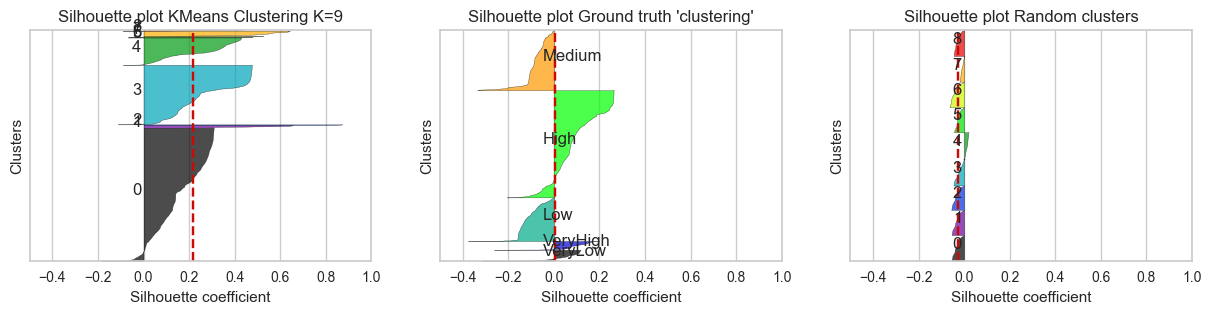

In [46]:
# Silhouette plots for Unique df with KMeans (X_u) 
fig = plt.figure(figsize=(15, 3))
ax1 = drawSilhouette(X_u_scaled, kms_X_u.labels_, header="KMeans Clustering K=9", pos=131)
ax2 = drawSilhouette(X_u_scaled, y_u, header="Ground truth 'clustering'", pos=132)
ax3 = drawSilhouette(X_u_scaled, rand_clust_u, header="Random clusters", pos=133)
plt.show()

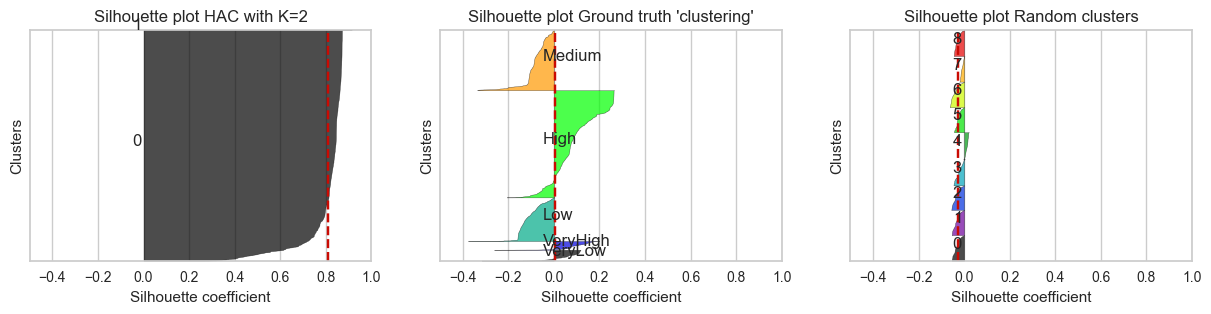

In [45]:
# Silhouette plots for Unique df with HAC (X_u) 
fig = plt.figure(figsize=(15, 3))
ax1 = drawSilhouette(X_u_scaled, hac_X_u.labels_, header="HAC with K=2", pos=131)
ax2 = drawSilhouette(X_u_scaled, y_u, header="Ground truth 'clustering'", pos=132)
ax3 = drawSilhouette(X_u_scaled, rand_clust_u, header="Random clusters", pos=133)
plt.show()

## 2.5 Discussion of the results

Based on these results, it seems that the clustering algorithm performed moderately well, with a silhoutte score of 0.35 and 0.22 for the train and unique datasets respectively. Moreover, the Calinski-Harabasz scores are very high, indicating that the clusters are certainly well separated. The negative effect of a low Calinski-Harabasz score can be seen in the last plot. The tuned HAC algorithm had a very promising silhoutte score close to 0.9, but visually we can see it's merely clustered everything together, which is far from ideal.
The Homogeneity, Completeness, and V-measure scores are all quite low for both datasets when using KMeans (lower still for HAC). Their scores are, however, a stark improvement when looking at the random clustering scores. These algorithms are far superior than mere random assignment. What is surprising is that the ground truth silhoutte plot has a coefficient score near 0, indicating that there is a lot of noise in the dataset that may impede efficient grouping into clustetrs. Overall, KMeans has proved to be the most robust clustering method, though more investigation and experimentation with different clustering algorithms and parameter settings may be needed to enhance the results further.